In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import datetime

def categorize(x):
    if x <= 30: return 0
    elif x <= 50: return 1
    else: return 2

def preprocess_3h(df):

    x = df.copy()

    x['category'] = x['Kp*10'].apply(categorize)

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 65)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,Lg_Dst,Kp*10,KpH,AE,lg(AE),ULFgr,lg(ULFgr),ULFgeo,lg(ULFgeo),ULFimf,lg(ULFimf),ULFden,lg(ULFden),B_rtn_r,B_rtn_t,B_rtn_n,B_x,B_gse_y,B_gse_z,B_gsm_y,B_gsm_z,B_magn,SW_spd,SW_spd_Clip290,H_den_SWP,lg(H_den_SWP),He_ratio_SWP,lg(He_ratio),Trr_SWP,lg(Trr),p=n*v*v/2,lg(p),Bs,vBs,E=vBmagn,?c=arctan(By/Bz),?2,E_KL,E_KLV,E_WAV,E_TL,dФ_MP/dt,E>0.8 MeV,"lg(E>0,8 MeV)",E>2 MeV,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,2.056905,13,13.0,97.0,1.986772,2.97,0.472756,1.03,0.012837,NaN,NaN,NaN,NaN,-0.5200,-2.8146,-0.4584,0.5109,2.7669,-0.6968,2.5359,-1.3079,2.9758,314.1321,314.1321,12.9222,1.111336,0.0048,-2.318759,19301.0,4.285580,637574.7335,5.804531,-1.3079,-410.853374,934.794303,-1.094625,204.009280,253.151859,15965.17718,68.556113,20964.85167,774.055916,NaN,NaN,5.191667,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,2.053078,7,11.0,79.0,1.897627,4.26,0.629410,0.29,-0.537602,NaN,NaN,NaN,NaN,-1.7296,-3.4436,-0.0115,1.7186,3.4354,-0.3063,3.0987,-1.5146,3.9844,314.1683,314.1683,8.7635,0.942678,0.0121,-1.917215,17707.0,4.248145,432486.2648,5.635972,-1.5146,-475.839307,1251.772175,-1.116160,392.233359,351.037444,20752.46157,98.442264,25675.02668,985.286740,NaN,NaN,2.082444,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,2.060698,10,8.0,172.0,2.235528,3.83,0.583199,0.99,-0.004365,NaN,NaN,NaN,NaN,0.3850,-2.0324,1.0187,-0.3912,2.1110,0.8411,2.2552,-0.2791,3.3428,311.0230,311.0230,14.8348,1.171282,0.0031,-2.508638,27439.0,4.438368,717524.4626,5.855837,-0.2791,-86.806519,1039.687684,-1.447664,668.542982,455.995881,29232.40459,199.994909,105077.64120,1569.908344,NaN,NaN,1.177167,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,2.053078,10,10.0,54.0,1.732394,3.94,0.595496,0.50,-0.301030,0.38,-0.420216,0.95,-0.022276,0.7018,-2.1733,0.5781,-0.7086,2.2126,0.3898,2.0875,-0.8307,2.5349,308.0456,308.0456,15.8484,1.199985,0.0044,-2.356547,27392.0,4.437624,751943.9129,5.876185,-0.8307,-255.893480,780.864791,-1.192067,196.569412,246.073855,15847.76606,77.545233,29967.63429,829.430645,NaN,NaN,3.173833,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,2.041393,7,9.0,150.0,2.176091,7.65,0.883661,0.20,-0.698970,0.30,-0.522879,NaN,NaN,3.7120,-2.3427,1.7193,-3.7192,2.4701,1.5132,2.8925,0.1565,4.7589,300.7700,300.7700,13.3870,1.126683,0.0069,-2.161151,27376.0,4.437370,605511.3656,5.782122,0.0000,0.000000,1431.334353,1.516744,1523.862187,677.002238,41721.05925,320.213114,166672.62320,2101.111435,NaN,NaN,10.257500,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 12:00:00


In [2]:
all_variables = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP', 'dttm', 'category'
 ]

predictors  = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP',
 ]

In [3]:
df[all_variables].isnull().sum()

Kp*10           0
Dst             0
B_x           120
B_gsm_y       120
B_gsm_z       120
B_magn        120
SW_spd       1116
H_den_SWP    1116
dttm            0
category        0
dtype: int64

In [4]:
def simple_preprocessing(df):
    x = df.copy()

    x = x.bfill()

    return x

def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'

            x = x.join(x.shift(lag).add_suffix(column_suffix))
        
        columns = x.columns.tolist()

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'
            tmp = x.loc[:, subset].shift(lag).add_suffix(column_suffix)
            columns.extend(tmp.columns)
            x = x.join(tmp)

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(column_name))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)

def get_train_test(df: pd.DataFrame, columns: list, 
                   forward_steps: int, backward_steps: int, 
                   last: str='24m') -> tuple:

    ts_df_back, lag_cols = add_lags(df, lags=backward_steps, forward=False, 
                                    trim=True, subset=columns, 
                                    return_cols=True)
    lag_cols.extend(columns)
    ts_df_back_test = ts_df_back.set_index('dttm').last(last)

    index_test = ts_df_back_test.index
    ts_df_back_train = ts_df_back.set_index('dttm').drop(index_test)

    df_train, lead_cols = add_lags(ts_df_back_train, lags=forward_steps,
                                   forward=True, trim=True, 
                                   subset='category', return_cols=True)
    df_test, lead_cols = add_lags(ts_df_back_test, lags=forward_steps, 
                                  forward=True, trim=True, 
                                  subset='category', return_cols=True)

    return df_train.reset_index(), lag_cols, df_test.reset_index(), lead_cols

In [5]:
df = df.loc[:, all_variables].pipe(simple_preprocessing)

In [6]:
df.head()

,Kp*10,Dst,B_x,B_gsm_y,B_gsm_z,B_magn,SW_spd,H_den_SWP,dttm,category
0,13,-14,0.5109,2.5359,-1.3079,2.9758,314.1321,12.9222,1997-10-21 00:00:00,0
3,7,-13,1.7186,3.0987,-1.5146,3.9844,314.1683,8.7635,1997-10-21 03:00:00,0
6,10,-15,-0.3912,2.2552,-0.2791,3.3428,311.0230,14.8348,1997-10-21 06:00:00,0
9,10,-13,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,1997-10-21 09:00:00,0
12,7,-10,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,1997-10-21 12:00:00,0


In [7]:
df_train, lag_cols, df_test, lead_cols = get_train_test(df, predictors, 24 // 3, 24)

In [8]:
X_train, y_train = df_train[lag_cols], df_train[lead_cols]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

In [9]:
X_train

,Kp*10_lag_01,Dst_lag_01,B_x_lag_01,B_gsm_y_lag_01,B_gsm_z_lag_01,B_magn_lag_01,SW_spd_lag_01,H_den_SWP_lag_01,Kp*10_lag_02,Dst_lag_02,B_x_lag_02,B_gsm_y_lag_02,B_gsm_z_lag_02,B_magn_lag_02,SW_spd_lag_02,H_den_SWP_lag_02,Kp*10_lag_03,Dst_lag_03,B_x_lag_03,B_gsm_y_lag_03,B_gsm_z_lag_03,B_magn_lag_03,SW_spd_lag_03,H_den_SWP_lag_03,Kp*10_lag_04,Dst_lag_04,B_x_lag_04,B_gsm_y_lag_04,B_gsm_z_lag_04,B_magn_lag_04,SW_spd_lag_04,H_den_SWP_lag_04,Kp*10_lag_05,Dst_lag_05,B_x_lag_05,B_gsm_y_lag_05,B_gsm_z_lag_05,B_magn_lag_05,SW_spd_lag_05,H_den_SWP_lag_05,...,Kp*10_lag_21,Dst_lag_21,B_x_lag_21,B_gsm_y_lag_21,B_gsm_z_lag_21,B_magn_lag_21,SW_spd_lag_21,H_den_SWP_lag_21,Kp*10_lag_22,Dst_lag_22,B_x_lag_22,B_gsm_y_lag_22,B_gsm_z_lag_22,B_magn_lag_22,SW_spd_lag_22,H_den_SWP_lag_22,Kp*10_lag_23,Dst_lag_23,B_x_lag_23,B_gsm_y_lag_23,B_gsm_z_lag_23,B_magn_lag_23,SW_spd_lag_23,H_den_SWP_lag_23,Kp*10_lag_24,Dst_lag_24,B_x_lag_24,B_gsm_y_lag_24,B_gsm_z_lag_24,B_magn_lag_24,SW_spd_lag_24,H_den_SWP_lag_24,Kp*10,Dst,B_x,B_gsm_y,B_gsm_z,B_magn,SW_spd,H_den_SWP
0,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,23.0,-6.0,0.4011,-4.3042,4.2987,9.0194,363.4272,16.0941,23.0,13.0,-0.5868,3.9192,4.4549,8.5077,343.8397,26.5408,17.0,10.0,2.9174,-2.9538,7.1968,8.5086,354.0109,45.5169,20.0,1.0,2.4410,-6.5211,7.4020,10.5716,366.8998,16.3880,...,10.0,-13.0,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,10.0,-15.0,-0.3912,2.2552,-0.2791,3.3428,311.0230,14.8348,7.0,-13.0,1.7186,3.0987,-1.5146,3.9844,314.1683,8.7635,13.0,-14.0,0.5109,2.5359,-1.3079,2.9758,314.1321,12.9222,23,-26,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500
1,23.0,-26.0,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,23.0,-6.0,0.4011,-4.3042,4.2987,9.0194,363.4272,16.0941,23.0,13.0,-0.5868,3.9192,4.4549,8.5077,343.8397,26.5408,17.0,10.0,2.9174,-2.9538,7.1968,8.5086,354.0109,45.5169,...,7.0,-10.0,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,10.0,-13.0,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,10.0,-15.0,-0.3912,2.2552,-0.2791,3.3428,311.0230,14.8348,7.0,-13.0,1.7186,3.0987,-1.5146,3.9844,314.1683,8.7635,27,-30,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069
2,27.0,-30.0,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069,23.0,-26.0,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,23.0,-6.0,0.4011,-4.3042,4.2987,9.0194,363.4272,16.0941,23.0,13.0,-0.5868,3.9192,4.4549,8.5077,343.8397,26.5408,...,3.0,-7.0,-1.6121,1.4664,0.5902,2.5267,302.8701,19.3569,7.0,-10.0,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,10.0,-13.0,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,10.0,-15.0,-0.3912,2.2552,-0.2791,3.3428,311.0230,14.8348,23,-31,0.5992,-1.9812,-5.6703,6.3549,375.3387,11.7977
3,23.0,-31.0,0.5992,-1.9812,-5.6703,6.3549,375.3387,11.7977,27.0,-30.0,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069,23.0,-26.0,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,23.0,-6.0,0.4011,-4.3042,4.2987,9.0194,363.4272,16.0941,...,0.0,-3.0,-0.6279,2.1574,0.8717,2.5102,300.2554,19.9338,3.0,-7.0,-1.6121,1.4664,0.5902,2.5267,302.8701,19.3569,7.0,-10.0,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,10.0,-13.0,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,43,-38,0.1098,-3.8007,-2.9401,5.6658,371.9948,25.9809
4,43.0,-38.0,0.1098,-3.8007,-2.9401,5.6658,371.9948,25.9809,23.0,-31.0,0.5992,-1.9812,-5.6703,6.3549,375.3387,11.7977,27.0,-30.0,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069,23.0,-26.0,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,...,7.0,5.0,0.3249,4.0838,1.8918,4.9587,307.3659,29.5693,0.0,-3.0,-0.6279,2.1574,0.8717,2.5102,300.2554,19.9338,3.0,-7.0,-1.6121,1.4664,0.5902,2.5267,302.8701,19.3569,7.0,-10.0,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,53,-45,7.7028,-18.7784,3.8986,21.1284,440.7002,22.4739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [10]:
f1_scores_models = {}

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(XGBClassifier(random_state=17, n_jobs=-1))

In [12]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(n_jobs=-1, random_state=17))

In [13]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score

from types import FunctionType

def columnwise_score(scoring_func: FunctionType, 
                     preds_df: pd.DataFrame, 
                     true_df: pd.DataFrame,
                     **kwargs) -> pd.Series:

    score = pd.Series(dtype='float64')
    for (column_pred, y_pred), (columns_true, y_true) in zip(preds_df.iteritems(), 
                                                             true_df.iteritems()):
        score[column_pred] = scoring_func(y_pred, y_true, **kwargs)
    
    return score

In [15]:
categories = list(sorted(df.category.unique()))

In [16]:
confusion_matrices = {
    col: pd.DataFrame(
        confusion_matrix(preds.loc[:, col], y_test.loc[:, col]),
        index=categories, columns=categories)
    for col in lead_cols
}

In [17]:
confusion_matrices['category_lead_1']

,0,1,2
0,5177,264,4
1,73,128,7
2,1,4,6


In [18]:
f1_macro_res = columnwise_score(f1_score, preds, y_test, average='macro')

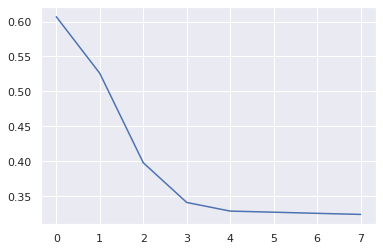

In [19]:
f1_macro_res.sort_index().reset_index(drop=True).plot()

In [20]:
f1_scores_models['xgb'] = f1_macro_res

In [21]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


model = make_pipeline(
    StandardScaler(),
    MultiOutputClassifier(RidgeClassifier(random_state=17)))

In [22]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=RidgeClassifier(random_state=17)))])

In [23]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)

In [24]:
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

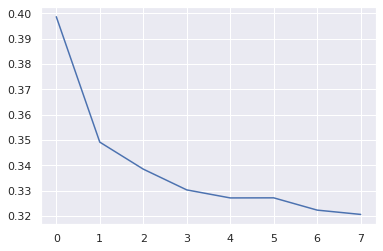

In [25]:
f1_weighted_res.reset_index(drop=True).plot()

In [26]:
f1_scores_models['ridge'] = f1_weighted_res

In [28]:
model =  MultiOutputClassifier(RandomForestClassifier(random_state=17, n_jobs=-1))

model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [29]:
f1_scores_models['rf'] = f1_weighted_res

In [30]:
pd.DataFrame(f1_scores_models)

,xgb,ridge,rf
category_lead_1,0.606813,0.398619,0.520659
category_lead_2,0.525858,0.349150,0.398798
category_lead_3,0.397866,0.338497,0.331501
category_lead_4,0.341030,0.330301,0.325469
category_lead_5,0.328670,0.327134,0.320626
category_lead_6,0.327120,0.327168,0.322429
category_lead_7,0.325469,0.322322,0.322393
category_lead_8,0.323929,0.320626,0.320626


In [31]:
model =  MultiOutputClassifier(SVC(random_state=17))

model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [32]:
f1_scores_models['svc'] = f1_weighted_res

In [34]:
pd.DataFrame(f1_scores_models).to_excel(os.path.join(ROOT_PATH, 'mvp_results_f1_macro.xlsx'))

In [ ]:
preds.sum()

category_lead_1    0.0
category_lead_2    0.0
category_lead_3    0.0
category_lead_4    0.0
category_lead_5    0.0
category_lead_6    0.0
category_lead_7    0.0
category_lead_8    0.0
dtype: float64